In [35]:
# Cell 1: Imports and Constants
import random
import pandas as pd
from collections import defaultdict
import numpy as np
import json
import matplotlib.pyplot as plt

VALID_RANKS = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
VALID_SUITS = ['H', 'D', 'C', 'S']
RANK_VALUES = {r: i+2 for i, r in enumerate(VALID_RANKS)}
RANK_NAMES = {v: k for k, v in RANK_VALUES.items()}



In [36]:
# Cell 2: Hand Evaluator
class HandEvaluator:
    @staticmethod
    def evaluate_hand(hand):
        values = sorted([RANK_VALUES[c[0]] for c in hand], reverse=True)
        suits = [c[1] for c in hand]
        
        flush = len(set(suits)) == 1
        
        unique = sorted(list(set(values)))
        straight = False
        for i in range(len(unique)-4):
            if unique[i] - unique[i+4] == 4:
                straight = True
                break
        if not straight and {14,2,3,4,5}.issubset(set(values)):
            straight, values = True, [5,4,3,2,1]
            
        count = {}
        for v in values: count[v] = count.get(v, 0) + 1
        sorted_counts = sorted(count.items(), key=lambda x: (-x[1], -x[0]))
        
        if straight and flush: return (8, max(values))
        if any(c[1]==4 for c in sorted_counts): return (7, sorted_counts[0][0])
        if len(sorted_counts)>1 and sorted_counts[0][1]==3 and sorted_counts[1][1]==2:
            return (6, sorted_counts[0][0])
        if flush: return (5, values)
        if straight: return (4, max(values))
        if sorted_counts[0][1] == 3: return (3, sorted_counts[0][0], values)
        if len(sorted_counts)>1 and sorted_counts[0][1]==2 and sorted_counts[1][1]==2:
            return (2, sorted_counts[0][0], sorted_counts[1][0], values)
        if sorted_counts[0][1] == 2: return (1, sorted_counts[0][0], values)
        return (0, values)

    @staticmethod
    def classify_hand(hand):
        score = HandEvaluator.evaluate_hand(hand)
        if score[0] == 8: return 'Straight Flush'
        if score[0] == 7: return 'Four of a Kind'
        if score[0] == 6: return 'Full House'
        if score[0] == 5: return 'Flush'
        if score[0] == 4: return 'Straight'
        if score[0] == 3: return 'Three of a Kind'
        if score[0] == 2: return 'Two Pair'
        if score[0] == 1: return f'Pair {RANK_NAMES[score[1]]}'
        high = max(score[1] if isinstance(score[1], list) else [score[1]])
        return f'High {RANK_NAMES[high]}' if high >= 11 else 'High Other'



In [37]:
# Cell 3 (Updated): Interactive Game with Post-Discard Decision
class InteractivePoker:
    def play_round(self):
        self.reset_game()
        print(f"Your hand: {self.player_hand}")
        print(f"Dealer's upcard: {self.dealer_hand[0]}")
        
        # Initial decision
        action = input("Fold, discard, or keep? (f/d/k): ").lower()
        if action == 'f':
            print("You folded. Lose $1.")
            return
        
        self.pot += 1  # Initial $1 bet
        
        if action == 'd':
            discard = input("Discard cards (space sep): ").upper().split()
            if discard:
                # Replace discarded cards
                self.player_hand = [c for c in self.player_hand if c not in discard]
                new_cards = [self.deck.pop() for _ in range(len(discard))]
                self.player_hand += new_cards
                self.pot += 2  # Add discard bet
                
                # Show new cards and final decision
                print("\nNew hand:", self.player_hand)
                final_action = input("Call (+$2) or fold? (c/f): ").lower()
                if final_action == 'f':
                    print(f"You folded. Lose ${self.pot//2}.")
                    return
                self.pot += 2  # Final call bet
                
        elif action == 'k':
            self.pot += 1  # Additional $1 call
        
        # Showdown
        player_score = HandEvaluator.evaluate_hand(self.player_hand)
        dealer_score = HandEvaluator.evaluate_hand(self.dealer_hand)
        
        print(f"\nDealer's hand: {self.dealer_hand}")
        print(f"Your final hand: {self.player_hand}")
        
        if player_score > dealer_score:
            print(f"You win ${self.pot}!")
        else:
            print(f"Dealer wins! You lose ${self.pot//2}")


In [38]:
# Cell 4: Enhanced Poker AI (Updated)
class EnhancedPokerAI:
    def __init__(self, matrix_path='hand_matrix6.csv'):
        self.hand_matrix = pd.read_csv(matrix_path, index_col=0)
        self.hand = []
        self.invested = 0
        self.visible_cards = set()
        self.last_ev_calculation = None
        self.last_post_ev = None
    
    def update_visible(self, new_cards):
        """Update tracked visible cards"""
        self.visible_cards.update(new_cards)
        
    def make_decision(self, dealer_upcard, visible_cards):
        self.update_visible(visible_cards)
        current_class = HandEvaluator.classify_hand(self.hand)
        
        # Immediate keeps for premium hands
        if current_class in ['Straight Flush', 'Flush', 'Full House', 'Straight']:
            return 'keep'
        
        # Generate proper discard candidates
        discard_candidates = self._get_discard_candidates(current_class)
        
        # Calculate EVs with correct bet sizing
        ev_fold = -1  # Fixed fold EV (blind is already lost)
        ev_keep = self._calculate_keep_ev(current_class, dealer_upcard[0])
        best_discard = self._evaluate_discards(discard_candidates, dealer_upcard)
        
        # Decision logic with proper strategy
        self.last_ev_calculation = {
            'fold': ev_fold,
            'keep': ev_keep,
            'discard': best_discard['ev']
        }
        
        if best_discard['ev'] > max(ev_keep, ev_fold):
            return ('discard', best_discard['cards'])
        elif ev_keep > ev_fold:
            return 'keep'
        else:
            return 'fold'
    
    def post_discard_decision(self, new_hand, dealer_upcard):
        """Second decision point after discarding"""
        self.hand = new_hand
        self.invested += 1  # Add discard bet
        current_class = HandEvaluator.classify_hand(self.hand)
        
        try:
            win_prob = self.hand_matrix.loc[current_class, dealer_upcard[0]]
        except KeyError:
            win_prob = 0.5  # Default for unknown hands
            
        # Final EV calculation
        ev_call = (win_prob * (self.invested + 2)) - ((1 - win_prob) * (self.invested + 2))
        ev_fold = -self.invested
        self.last_post_ev = {
            'call': ev_call,
            'fold': ev_fold
        }  # Fixed closing brace
        return 'call' if ev_call > ev_fold else 'fold'

    def _get_discard_candidates(self, hand_type):
        """Proper discard candidate generation per strategy"""
        candidates = []
        hand_ranks = [c[0] for c in self.hand]
        
        if hand_type.startswith('Pair'):
            # Discard all non-paired cards
            paired_rank = hand_type.split()[-1]
            candidates = [[c for c in self.hand if c[0] != paired_rank]]
        elif hand_type == 'Two Pair':
            # Discard single kicker
            pairs = list({r for r in hand_ranks if hand_ranks.count(r) == 2})
            candidates = [[c for c in self.hand if c[0] not in pairs]]
        elif hand_type in ['Three of a Kind', 'Four of a Kind']:
            # Discard non-paired cards
            paired_rank = max(set(hand_ranks), key=hand_ranks.count)
            candidates = [[c for c in self.hand if c[0] != paired_rank]]
        else:
            # Draw detection logic
            if self._has_flush_draw():
                main_suit = max(set(c[1] for c in self.hand), 
                              key=[c[1] for c in self.hand].count)
                candidates = [[c for c in self.hand if c[1] != main_suit]]
            elif self._has_straight_draw():
                candidates = [self._find_straight_blockers()]
            else:
                # Discard lowest 3 unpaired cards
                unpaired = [c for c in self.hand if hand_ranks.count(c[0]) == 1]
                candidates = [sorted(unpaired, key=lambda x: RANK_VALUES[x[0]])[:3]]
                
        return candidates
    
    def _evaluate_discards(self, candidates, dealer_upcard):
        """Proper EV calculation with post-discard decision"""
        best = {'ev': -float('inf'), 'cards': []}
        remaining = [c for c in ALL_CARDS if c not in self.visible_cards]
        
        for discard in candidates:
            if len(discard) == 0 or len(remaining) < len(discard):
                continue
                
            # Simulate discard and draw
            new_hand = [c for c in self.hand if c not in discard]
            new_hand += random.sample(remaining, len(discard))
            new_class = HandEvaluator.classify_hand(new_hand)
            
            # Calculate post-discard EV
            try:
                win_prob = self.hand_matrix.loc[new_class, dealer_upcard[0]]
            except KeyError:
                win_prob = 0.5
                
            # Total investment: $1 (blind) + $1 (discard) + $2 (call) = $4
            call_ev = (win_prob * 4) + ((1 - win_prob) * -4)
            fold_ev = -2  # Already invested $2
            best_post_ev = max(call_ev, fold_ev)
            
            total_ev = best_post_ev
            
            if total_ev > best['ev']:
                best = {'ev': total_ev, 'cards': discard}
        
        return best
    
    def _calculate_improvement_prob(self, discard, possible_outs):
        """Calculate probability of hand improvement"""
        # Implementation depends on specific hand analysis
        # Simplified version using card counts
        needed_ranks = [c[0] for c in self.hand if c not in discard]
        outs = len([c for c in possible_outs if c[0] in needed_ranks])
        return outs / len(possible_outs) if len(possible_outs) > 0 else 0
    
    def _calculate_keep_ev(self, hand_type, dealer_rank):
        """Calculate EV for keeping current hand"""
        try:
            win_prob = self.hand_matrix.loc[hand_type, dealer_rank]
        except KeyError:
            win_prob = 0.5
        return (win_prob * (self.invested + 2)) - ((1 - win_prob) * (self.invested + 2))
    
    def _has_flush_draw(self):
        suits = [c[1] for c in self.hand]
        return any(suits.count(s) >= 4 for s in set(suits))
    
    def _has_straight_draw(self):
        values = sorted([RANK_VALUES[c[0]] for c in self.hand])
        gaps = values[-1] - values[0]
        return gaps <= 4 and len(set(values)) >= 4
    def _find_straight_blockers(self):
        """NEW METHOD - Identify straight-blocking cards"""
        values = sorted([RANK_VALUES[c[0]] for c in self.hand])
        blockers = []
        
        # Check for open-ended straight draws (e.g., 5-6-7-8)
        for i in range(len(values)-3):
            sequence = values[i:i+4]
            if sequence[-1] - sequence[0] == 3:
                needed = [sequence[0]-1, sequence[-1]+1]
                blockers = [c for c in self.hand 
                           if RANK_VALUES[c[0]] not in sequence]
                return blockers[:1]

        # Check for gutshot draws (e.g., 4-5-7-8)
        for i in range(len(values)-3):
            sequence = values[i:i+4]
            if sequence[-1] - sequence[0] == 4 and len(set(sequence)) == 4:
                missing = list(set(range(sequence[0], sequence[-1]+1)) - set(sequence))
                blockers = [c for c in self.hand 
                           if RANK_VALUES[c[0]] not in range(sequence[0], sequence[-1]+1)]
                return blockers[:1]

        # Fallback: Discard highest gap
        gaps = [(values[i+1] - values[i], i) for i in range(len(values)-1)]
        max_gap = max(gaps, key=lambda x: x[0])[1]
        return [self.hand[max_gap + 1]]

    

# Define ALL_CARDS for reference
ALL_CARDS = [r+s for s in VALID_SUITS for r in VALID_RANKS]

In [48]:
# Cell 5: Enhanced Simulation with Real Hand Comparison
def simulate_ai_games(n_players=1000, n_games=100):
    all_results = []
    all_histories = []
    hand_stats = {
        'initial': defaultdict(int),
        'post_discard': defaultdict(int)
    }
    fold_stats = {
        'initial': 0,
        'post_discard': 0
    }
    showdown_stats = {
        'wins': 0,
        'losses': 0,
        'ties': 0
    }
    player_profits = []

    for player in range(n_players):
        balance = 100
        history = [balance]
        
        for _ in range(n_games):
            # Generate fresh deck and deal hands
            deck = [r+s for s in VALID_SUITS for r in VALID_RANKS]
            random.shuffle(deck)
            
            player_hand = deck[:5]
            dealer_hand = deck[5:10]
            dealer_up = dealer_hand[0]
            
            ai = EnhancedPokerAI()
            ai.hand = player_hand.copy()
            ai.visible_cards = set(player_hand + [dealer_up])
            ai.invested = 1
            balance -= 1
            
            # Track initial hand
            initial_class = HandEvaluator.classify_hand(player_hand)
            hand_stats['initial'][initial_class] += 1
            
            # First decision
            decision = ai.make_decision(dealer_up, ai.visible_cards)
            
            if decision == 'fold':
                fold_stats['initial'] += 1
                history.append(balance)
                continue
                
            if decision == 'keep':
                ai.invested += 1
                balance -= 1
            elif decision[0] == 'discard':
                # Process discard
                discard = decision[1]
                remaining_deck = deck[10:]  # After initial 10 cards
                new_cards = remaining_deck[:len(discard)]
                ai.hand = [c for c in ai.hand if c not in discard] + new_cards
                ai.invested += 1
                balance -= 1
                
                # Post-discard decision
                final_decision = ai.post_discard_decision(ai.hand, dealer_up)
                if final_decision == 'fold':
                    fold_stats['post_discard'] += 1
                    history.append(balance)
                    continue
                    
                ai.invested += 2
                balance -= 2
            
            # Showdown - compare actual hands
            player_score = HandEvaluator.evaluate_hand(ai.hand)
            dealer_score = HandEvaluator.evaluate_hand(dealer_hand)
            
            if player_score > dealer_score:
                balance += ai.invested * 2
                showdown_stats['wins'] += 1
            elif player_score < dealer_score:
                showdown_stats['losses'] += 1
            else:
                balance += ai.invested  # Return bet on tie
                showdown_stats['ties'] += 1
                
            # Track post-discard hand if applicable
            if decision[0] == 'discard':
                post_class = HandEvaluator.classify_hand(ai.hand)
                hand_stats['post_discard'][post_class] += 1
                
            history.append(balance)
        
        player_profits.append(balance - 100)
        all_histories.append(history)

    # Calculate statistics
    total_games = n_players * n_games
    total_showdowns = showdown_stats['wins'] + showdown_stats['losses'] + showdown_stats['ties']
    
    return {
        'hand_stats': hand_stats,
        'fold_stats': fold_stats,
        'showdown_stats': {
            'win_pct': showdown_stats['wins'] / total_showdowns if total_showdowns > 0 else 0,
            'loss_pct': showdown_stats['losses'] / total_showdowns if total_showdowns > 0 else 0,
            'tie_pct': showdown_stats['ties'] / total_showdowns if total_showdowns > 0 else 0
        },
        'player_profits': player_profits,
        'all_histories': all_histories
    }



Showdown Win %: 64.3%
Fold Rates: Initial 1.9%, Post-Discard 1.3%


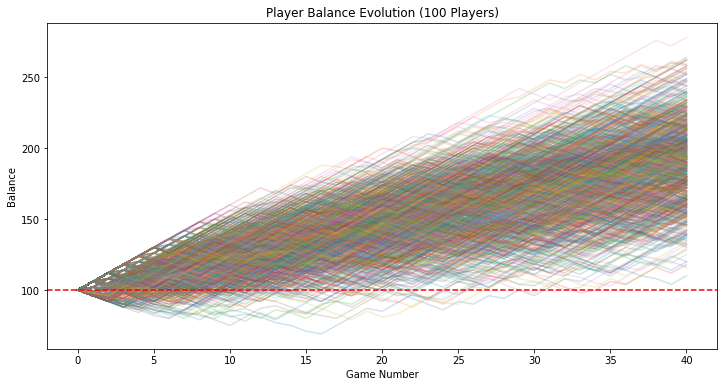

In [51]:
# Cell 6: Updated Main Execution
if __name__ == "__main__":
    n_players = 1000
    n_games = 40
    results = simulate_ai_games(n_players, n_games)
    
    print(f"Showdown Win %: {results['showdown_stats']['win_pct']:.1%}")
    print(f"Fold Rates: Initial {results['fold_stats']['initial']/(n_players*n_games):.1%}, "
          f"Post-Discard {results['fold_stats']['post_discard']/(n_players*n_games):.1%}")
    
    # Plot performance
    plt.figure(figsize=(12, 6))
    for hist in results['all_histories']:
        plt.plot(hist, alpha=0.2)
    plt.title("Player Balance Evolution (1000 Players)")
    plt.xlabel("Game Number")
    plt.ylabel("Balance")
    plt.axhline(100, color='red', linestyle='--')
    plt.show()

In [53]:
# Cell 5b: Enhanced AI Observer with Readable Formatting
def format_ai_log(ai_log):
    """Convert raw AI log to human-readable format"""
    formatted = []
    for entry in ai_log:
        # Basic game info
        output = [
            f"Game {entry['game']}. Dealer card [{entry['dealer_up']}]",
            f"Initial hand: {entry.get('initial_cards', [])} {entry['initial_hand']}"
        ]
        
        # Initial decision EVs
        initial_evs = entry['actions'][0]['ev']
        ev_line = "Initial EVs: "
        ev_line += f"fold: {initial_evs['fold']:.2f}; "
        ev_line += f"keep: {initial_evs['keep']:.2f}; "
        if 'discard' in initial_evs:
            ev_line += f"discard: {initial_evs['discard']:.2f}"
        output.append(ev_line)
        
        # Discard decision if present
        if len(entry['actions']) > 1:
            discard_evs = entry['actions'][1]['ev']
            output.append(f"Post-discard EVs: call: {discard_evs['call']:.2f}; fold: {discard_evs['fold']:.2f}")
        
        # Final outcome
        output.append(f"Final hand: {entry.get('final_cards', [])} {entry['final_hand']}")
       # output.append(f"Result: {entry.get('result', 'N/A').upper()}")
        output.append("─" * 50)
        
        formatted.append("\n".join(output))
    
    return "\n\n".join(formatted)

# Updated observe_ai_games function with proper tracking
def observe_ai_games(n=100):
    log = []
    for game in range(n):
        deck = [r+s for s in VALID_SUITS for r in VALID_RANKS]
        random.shuffle(deck)
        ai = EnhancedPokerAI()
        ai.hand = deck[:5]
        ai.invested = 1  # Fixed initial investment
        dealer_up = deck[5]
    
    for game in range(n):
        # Reset for each game
        ai = EnhancedPokerAI()  # Fresh AI for each game
        balance = 100
        deck = [r+s for s in VALID_SUITS for r in VALID_RANKS]
        random.shuffle(deck)
        
        ai.hand = deck[:5]
        dealer_up = deck[5]
        visible = ai.hand.copy() + [dealer_up]
        result = None
        
        log_entry = {
            'game': game+1,
            'dealer_up': dealer_up,
            'initial_cards': ai.hand.copy(),
            'initial_hand': HandEvaluator.classify_hand(ai.hand),
            'actions': [],
            'final_cards': None,
            'final_hand': None,
            'result': None,
            'balance': balance
        }
        
        # Initial decision
        decision = ai.make_decision(dealer_up, visible)
        log_entry['actions'].append({
            'stage': 'initial',
            'decision': decision,
            'ev': ai.last_ev_calculation
        })
        
        if decision == 'fold':
            log_entry['result'] = 'fold'
            log_entry['balance'] = balance - 1
            log.append(log_entry)
            continue
            
        if decision == 'keep':
            balance -= 1
            ai.invested += 1
        elif decision[0] == 'discard':
            balance -= 1  # Discard cost
            ai.invested += 1
            
            # Process discard
            discard = decision[1]
            remaining = [c for c in deck if c not in visible + discard]
            new_cards = random.sample(remaining, len(discard))
            ai.hand = [c for c in ai.hand if c not in discard] + new_cards
            
            # Post-discard decision
            final_decision = ai.post_discard_decision(ai.hand, dealer_up)
            log_entry['actions'].append({
                'stage': 'post_discard',
                'decision': final_decision,
                'ev': ai.last_post_ev
            })
            
            if final_decision == 'fold':
                log_entry['result'] = 'fold'
                balance -= ai.invested
            else:
                balance -= 2  # Final call bet
                ai.invested += 2
                
                # Showdown
                try:
                    win_prob = ai.hand_matrix.loc[
                        HandEvaluator.classify_hand(ai.hand), 
                        dealer_up[0]
                    ]
                except KeyError:
                    win_prob = 0.5
                
                if random.random() < win_prob:
                    balance += ai.invested * 2
                    log_entry['result'] = 'win'
                else:
                    log_entry['result'] = 'loss'
        
        # Update final state
        log_entry['final_cards'] = ai.hand.copy()
        log_entry['final_hand'] = HandEvaluator.classify_hand(ai.hand)
        log_entry['balance'] = balance
        log.append(log_entry)
    
    return log

# Cell 6: Updated Main Execution
if __name__ == "__main__":
    # Run AI observer
    ai_log = observe_ai_games(10)  # 10 games for demo
    
    # Print formatted output
    print("\nAI DECISION LOG:")
    print(format_ai_log(ai_log))


AI DECISION LOG:
Game 1. Dealer card [JD]
Initial hand: ['TD', 'QS', '3H', '7D', 'TC'] Pair T
Initial EVs: fold: -1.00; keep: 0.72; discard: 1.44
Post-discard EVs: call: 4.00; fold: -2.00
Final hand: ['TD', 'TC', 'TH', '7C', '4C'] Three of a Kind
──────────────────────────────────────────────────

Game 2. Dealer card [9D]
Initial hand: ['KH', 'AD', '5S', 'KS', '8C'] Pair K
Initial EVs: fold: -1.00; keep: 1.64; discard: 3.28
Post-discard EVs: call: 4.00; fold: -2.00
Final hand: ['KH', 'KS', '2C', '9S', 'KD'] Three of a Kind
──────────────────────────────────────────────────

Game 3. Dealer card [TD]
Initial hand: ['3D', 'KH', '8H', '8S', 'TC'] Pair 8
Initial EVs: fold: -1.00; keep: 0.44; discard: 0.88
Post-discard EVs: call: 0.88; fold: -2.00
Final hand: ['8H', '8S', '3H', 'QC', 'KD'] Pair 8
──────────────────────────────────────────────────

Game 4. Dealer card [2S]
Initial hand: ['3S', '7H', 'AC', 'KH', '5H'] High A
Initial EVs: fold: -1.00; keep: -0.08; discard: -0.16
Final hand: ['

In [42]:
# Cell 5a: Updated Simulation with Enhanced Tracking
def simulate_ai_games_OLD(n_players=1000, n_games=100):
    sim_results = {}
    player_profits = {}
    all_results = []
    hand_stats = {
        'initial': defaultdict(int),
        'post_discard': defaultdict(int)
    }
    fold_stats = {
        'initial': 0,
        'post_discard': 0
    }
    player_profits = []
    all_histories = []

    for player in range(n_players):
        ai = EnhancedPokerAI()
        balance = 100
        history = [balance]
        
        for _ in range(n_games):
            deck = [r+s for s in VALID_SUITS for r in VALID_RANKS]
            random.shuffle(deck)
            
            ai.hand = deck[:5]
            dealer_up = deck[5]
            visible = ai.hand.copy() + [dealer_up]
            ai.visible_cards = set(visible)
            ai.invested = 1
            balance -= 1
            
            # Track initial hand
            initial_hand = HandEvaluator.classify_hand(ai.hand)
            hand_stats['initial'][initial_hand] += 1
            
            # First decision
            decision = ai.make_decision(dealer_up, visible)
            
            if decision == 'fold':
                fold_stats['initial'] += 1
                history.append(balance)
                continue
                
            if decision == 'keep':
                ai.invested += 1
                balance -= 1
            elif decision[0] == 'discard':
                discard = decision[1]
                ai.visible_cards.update(discard)
                remaining = [c for c in deck if c not in ai.visible_cards]
                
                new_cards = random.sample(remaining, len(discard))
                ai.hand = [c for c in ai.hand if c not in discard] + new_cards
                ai.visible_cards.update(new_cards)
                
                # Post-discard decision
                final_decision = ai.post_discard_decision(ai.hand, dealer_up)
                if final_decision == 'fold':
                    fold_stats['post_discard'] += 1
                    balance -= ai.invested
                    history.append(balance)
                    continue
                    
                # Only track post-discard hands that went to showdown
                post_hand = HandEvaluator.classify_hand(ai.hand)
                hand_stats['post_discard'][post_hand] += 1
                
                ai.invested += 2
                balance -= 2
            
            # Resolve showdown
            try:
                win_prob = ai.hand_matrix.loc[
                    HandEvaluator.classify_hand(ai.hand), 
                    dealer_up[0]
                ]
            except KeyError:
                win_prob = 0.5
                
            if random.random() < win_prob:
                balance += ai.invested * 2
            history.append(balance)
        
        player_profits.append(balance - 100)
        all_histories.append(history)

    # Calculate statistics
    total_games = n_players * n_games
    total_profit = sum(player_profits)
    ev_per_game = total_profit / total_games
    
    # Calculate pair percentages
    pair_stats = {
        'initial': sum(v for k,v in hand_stats['initial'].items() if 'Pair' in k) / total_games,
        'post_discard': sum(v for k,v in hand_stats['post_discard'].items() if 'Pair' in k) / total_games
    }
    #std_dev = np.std(sim_results['player_profits'])
    #profitable_pct = len([p for p in sim_results['player_profits'] if p > 0]) / n_players
    return {
        'hand_stats': hand_stats,
        'fold_stats': fold_stats,
        'pair_stats': pair_stats,
        'ev_per_game': ev_per_game,
        'all_histories': all_histories,
        
    }

# Cell 5b: Fixed AI Observer Mode
def observe_ai_games(n=100):
    log = []
    for game in range(n):
        ai = EnhancedPokerAI()
        ai.hand = deck[:5]
        ai.invested = 1  # Fixed initial investment
        dealer_up = deck[5]
    
    for game in range(n):
        deck = [r+s for s in VALID_SUITS for r in VALID_RANKS]
        random.shuffle(deck)
        
        ai.hand = deck[:5]
        dealer_up = deck[5]
        visible = ai.hand.copy() + [dealer_up]
        ai.visible_cards = set(visible)
        ai.invested = 1
        balance -= 1
        
        log_entry = {
            'game': game+1,
            'initial_hand': HandEvaluator.classify_hand(ai.hand),
            'dealer_up': dealer_up,
            'actions': []
        }
        
        # First decision
        decision = ai.make_decision(dealer_up, visible)
        log_entry['actions'].append({
            'stage': 'initial',
            'decision': decision,
            'ev': ai.last_ev_calculation
        })
        
        if decision == 'fold':
            log_entry['balance'] = balance
            log.append(log_entry)
            continue
            
        if decision == 'keep':
            ai.invested += 1
            balance -= 1
        elif decision[0] == 'discard':
            discard = decision[1]
            # Convert single card to list if needed
            if isinstance(discard, str):
                discard = [discard]
                
            remaining = [c for c in deck if c not in visible + discard]
            new_cards = random.sample(remaining, len(discard))
            ai.hand = [c for c in ai.hand if c not in discard] + new_cards
            
            # Post-discard decision
            final_decision = ai.post_discard_decision(ai.hand, dealer_up)
            log_entry['actions'].append({
                'stage': 'post_discard',
                'decision': final_decision,
                'ev': ai.last_post_ev
            })
            
            if final_decision == 'fold':
                balance -= ai.invested
            else:
                ai.invested += 2
                balance -= 2
                
                # Showdown
                try:
                    win_prob = ai.hand_matrix.loc[
                        HandEvaluator.classify_hand(ai.hand), 
                        dealer_up[0]
                    ]
                except KeyError:
                    win_prob = 0.5
                    
                if random.random() < win_prob:
                    balance += ai.invested * 2
        
        log_entry['balance'] = balance
        log_entry['final_hand'] = HandEvaluator.classify_hand(ai.hand)
        log.append(log_entry)
    
    return log
